In [2]:
import scipy
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp, mannwhitneyu, spearmanr, pearsonr
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib
import os
import pickle
import os, fnmatch
from os import listdir
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile

In [34]:
get_ipython().run_line_magic('cd', '/Users/deepanshishokeen/desktop/capstone/work/amplitude-modulation-analysis-module')
from am_analysis import am_analysis as ama
mpl=matplotlib.pyplot
mod_feat = 'power_modulation_spectrogram' # Controls which version of the amplitude modulation spectrogram

/Users/deepanshishokeen/Desktop/Capstone/work/amplitude-modulation-analysis-module


In [35]:
rms = lambda x: np.sqrt(np.square(x).mean())
dB = lambda y: 10*np.log10(y)
objfun = lambda x: dB((np.mean(x,0).squeeze())+10**(-12))

In [36]:
from statistics import mean
def abs_mod(mod_spec, f_range=np.array([500,4000]), modf_range=np.array([30,60]), c_range=np.array([20,80]), ttl=None, avg=False, ref=None):
    print("Freq Range:", f_range, ", ModFreq Range:", modf_range)
    mn=mod_spec[mod_feat] 
    amx=mod_spec['freq_mod_axis']
    amy=mod_spec['freq_axis']
    midx=np.where((amx>=modf_range[0]) & (amx<modf_range[1]))[0]
    midy=np.where((amy>=f_range[0]) & (amy<f_range[1]))[0]
    if ref is None: 
        rf=mn
    else:
        rf = ref
    w = objfun(mn[midy][:,midx,:])
    print(sum(w))
    print(mean(w))
    p = sum(w), mean(w)
    if ref is not None:
        objfun(rf[midy][:,midx,:])
    return p[0],p[1]

In [37]:
def abs_avg_mod(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', t_range=None, FL=2, FR=1, N=1024, hop=0.005):
    fs,x = scipy.io.wavfile.read(fname, mmap=True)
    print(fs,len(x))
    if not len(x):
        print( "File not read:", fname )
        return
    else:
        print ( "Loaded",fname,"len:",len(x) )
    win_size = int(fs*FL)
    win_shift = int(fs/FR)
    if t_range is None:
        t_range = [60,120]
    sig = x[t_range[0]*fs:t_range[1]*fs,0].reshape(-1,1) # LEFT CHANNEL
    sig = sig / rms(sig) # normalize RMS 
    x_segmented, _, _ = ama.epoching(sig, win_size, win_size-win_shift)
    n_segments  = x_segmented.shape[2]
    mod_spec = []
    for i_segment in range(0,n_segments):
        x_tmp = x_segmented[:,:,i_segment]
        ms=ama.strfft_modulation_spectrogram(x_tmp, fs, N, int(fs*hop))
        mod_spec.append(ms)
    data = []
    for m in mod_spec:    
        data.append(m[mod_feat][:,:,0])
    data = np.array(data)    
    nmm = data.mean(0) # average modulation spectrum
    mod_spec[0][mod_feat][:,:,0]=nmm
    return mod_spec[0]

In [38]:
# Default is K448
def get_mod_spec(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', avg=False, hist=False, plotting=True, ref=None):
    res = []
    abs_sum = []
    abs_mean = []
    for t in T:
        res.append(abs_avg_mod(fname=fname, t_range=[t*60,(t+1)*60]))
        if plotting:
            abs=abs_mod(res[t], ttl='%s, T=%02d:00-%02d:00'%(ttl,t,t+1), avg=avg, ref=ref)
            abs_sum.append(abs[0])
            abs_mean.append(abs[1])
    return res, abs_sum, abs_mean


In [39]:
matplotlib.rcParams['figure.figsize']=(12,6)
def make_reference_mod_spec(x):
    y=np.array([r[mod_feat] for r in x]).mean(0)
    return y

In [40]:
res_448, sum_448, mean_448 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', avg=True)


44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2411.855418643153
-40.87890540073141
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2351.2580352031523
-39.85183110513818
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2234.6758638823762
-37.875862099701294


In [41]:
ref_448 = make_reference_mod_spec(res_448)
res_448, sum_448, mean_448 = get_mod_spec(avg=True, ref=ref_448)

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2411.855418643153
-40.87890540073141
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2351.2580352031523
-39.85183110513818
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2234.6758638823762
-37.875862099701294


In [42]:
sum_448

[-2411.855418643153, -2351.2580352031523, -2234.6758638823762]

In [43]:
mean_448

[-40.87890540073141, -39.85183110513818, -37.875862099701294]

ref_448 = make_reference_mod_spec(res_448)
res_448, w_448 = get_mod_spec(avg=True, ref=ref_448)

In [44]:
res_545, sum_545, mean_545 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav', ttl='Mozart K545', ref=ref_448, avg=True)


44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2722.415811662747
-46.142640875639785
44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2507.445266896896
-42.49907232028637
44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2357.1841536360844
-39.95227379044211


In [45]:
#my_list=[]
#mypath= '/Volumes/LaCie/Preferred Music Corpus/Country'
#for root, dirnames, filenames in os.walk(mypath):
 #   for filename in filenames:
  #      if filename.endswith('.wav'):
   #             files.append(os.path.join(filename))

#z = []
#slash='/'
#for j in files:
 #   ttl=j.replace('.wav','')
  #  res,abs_sum,abs_mean=get_mod_spec(mypath+slash+j,ttl=ttl, ref=ref_448)
   # ttl=[ttl,ttl,ttl]
    #for i in range(3):
     #   z=ttl[i],abs_sum[i],abs_mean[i]
      #  my_list.append(z)

In [21]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Non-western'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
print(len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))


z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)

20
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2460.268162223878
-41.69946037667591
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2446.878647193901
-41.47251944396442
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2625.2254886762844
-44.49534726569973
44100 6769056
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/07 Various - Punleu Prey Viel (Cambodia).wav len: 6769056
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2569.910254037432
-43.55780091588868
44100 6769056
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/07 Various - Punleu Prey Viel (Cambodia).wav len: 67690

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3246.977830645441
-55.03352255331255
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2298.3834639414604
-38.955651931211186
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2954.910253214457
-50.083224630753506
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2272.1822107966427
-38.51156289485835
44100 8869980
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/19 Various - Anasazi Visions (U.S.A).wav len: 8869980
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3320.8227595190892
-56.2851315172727
44100 8869980
Loaded /Volumes/LaCie/P

In [24]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/non_western.xlsx')  
df_nw = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/non_western.xlsx')

In [25]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Heavy Metal'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1314.415655322768
-22.278231446148613
44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1139.7270729532063
-19.317408016156037
44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-999.335273836704
-16.93788599723227
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - Old School Hollywood.wav len: 7799820


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - Old School Hollywood.wav len: 7799820


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - Old School Hollywood.wav len: 7799820
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-536.3347110145344
-9.09041883075482
44100 19361076
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Judas Priest - Starbreaker [Live 9.05.1978 in Cleveland, The United States].wav len: 19361076
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1142.1433110660366
-19.35836120450909
44100 19361076
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Judas Priest - Starbreaker [Live 9.05.1978 in Cleveland, The United States].wav len: 19361076
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 19361076
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Judas Priest - Starbreaker [Live 9.05.1978 in Cleveland, The United States].wav len: 19361076
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 12553800
Lo

Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 14076720
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Judas Priest - Love Bites [Live 23.05.1986 in St. Louis, The United States].wav len: 14076720
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-889.3678054644527
-15.074030601092414
44100 14076720
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Judas Priest - Love Bites [Live 23.05.1986 in St. Louis, The United States].wav len: 14076720
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 14076720
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Judas Priest - Love Bites [Live 23.05.1986 in St. Louis, The United States].wav len: 14076720
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-167.5153159753187
-2.83924264364947
44100 10940916
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/09 Quiet Riot - Let's Get Crazy - Quiet Riot.wav len: 10940916
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1189.2505289323378
-

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1302.9597613285669
-22.08406375133164
44100 26938044
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Sunn O))) - Cursed Realms (Of The Winterdemons).wav len: 26938044
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 9319800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 System Of A Down - Violent Pornography.wav len: 9319800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-472.24210901550236
-8.004103542635633
44100 9319800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 System Of A Down - Violent Pornography.wav len: 9319800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-382.5075969927156
-6.483179610046028
44100 9319800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 System Of A Down - Violent Pornography.wav len: 9319800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-437.33325019329874
-7.412427969377943
44100 16472820
Loaded /Volumes/LaCie/Preferred Music Corpus/H

Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 8152620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Nickelback - Hollywood.wav len: 8152620
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-394.8171825967956
-6.691816654182973
44100 8152620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Nickelback - Hollywood.wav len: 8152620
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 8152620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Nickelback - Hollywood.wav len: 8152620
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 16099440
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/05 Judas Priest - Painkiller.wav len: 16099440
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 16099440
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/05 Judas Priest - Painkiller.wav len: 16099440
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 16099440
Loaded /Volumes/LaCie/Preferred M

Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 12653760
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Devil's Child.wav len: 12653760
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-620.0200990238213
-10.508815237691884
44100 12653760
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Devil's Child.wav len: 12653760
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 12653760
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Devil's Child.wav len: 12653760
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 11299008
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Delivering the Goods.wav len: 11299008
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-457.6451368954546
-7.756697235516181
44100 11299008
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Judas Priest - Delivering the Goods.wav len: 11299008
Freq Range: [1414 2828] , ModF

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-960.751826566071
-16.28392926383171
44100 8025024
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Judas Priest - Take On the World.wav len: 8025024
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-599.0221281607838
-10.152917426453966
44100 8025024
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Judas Priest - Take On the World.wav len: 8025024
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-601.8324104028007
-10.200549328861033
44100 8025024
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Judas Priest - Take On the World.wav len: 8025024
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-525.9809610894616
-8.914931543889178
44100 9748452
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Motörhead - Bomber.wav len: 9748452
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-45.50973599424762
-0.7713514575296206
44100 9748452
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Motör

Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 14424816
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/12 Judas Priest - Bloodstained.wav len: 14424816
Freq Range: [1414 2828] , ModFreq Range: [30 60]
269.22484972062927
4.563133046112359
44100 10929744
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Judas Priest - Some Heads Are Going to Roll.wav len: 10929744
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 10929744
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Judas Priest - Some Heads Are Going to Roll.wav len: 10929744
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 10929744
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Judas Priest - Some Heads Are Going to Roll.wav len: 10929744
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 9075780
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/09 System Of A Down - Sad Statue.wav len: 9075780
Freq Range: [1414 2828] , ModFreq

Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 15182160
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 Judas Priest - A Touch of Evil.wav len: 15182160
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-80.60895316293474
-1.3662534434395721
44100 15182160
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 Judas Priest - A Touch of Evil.wav len: 15182160
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 15182160
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 Judas Priest - A Touch of Evil.wav len: 15182160
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 7021308
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Motörhead - No Class.wav len: 7021308
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 7021308
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/06 Motörhead - No Class.wav len: 7021308
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 7021308
Loaded /Volumes

In [26]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/heavy_metal.xlsx') 
df_hm = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/heavy_metal.xlsx')

In [27]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Country/Classic Country'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2114.667438474874
-35.84182099109957
44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2143.0216914865564
-36.32240155061961
44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2208.748438823489
-37.43641421734726
44100 8601264
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Ray Charles - You Don't Know Me.wav len: 8601264
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1948.5304789138656
-33.02594032057399
44100 8601264
Loaded

Freq Range: [1414 2828] , ModFreq Range: [30 60]
22.14501604795321
0.37533925505005483
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1864.0448301800536
-31.59398017254328
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1499.1911606518443
-25.410019672065154
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1744.7936908871648
-29.572774421816344
44100 7472304
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Jimmie Davis - You Are My Sunshine.wav len: 7472304
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1771.828362241789
-30.030989190538794
44100 7472304
Loaded /Volumes/LaCie/P

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1832.7320439648431
-31.06325498245497
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2017.61276555389
-34.19682653481169
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1808.1244513828506
-30.646177142082212
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1797.9560750073285
-30.473831779785222
44100 6809040
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Eddy Arnold - I Really Don't Want to Know.wav len: 6809040
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1652.29126789728
-28.004936744021702
44100 68090

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1635.7585528724937
-27.724721235127017
44100 7879788
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/13 Ray Charles - You Are My Sunshine.wav len: 7879788
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1507.7037268291563
-25.55430045473146
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1963.2818199528847
-33.2759630500489
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2203.0321270719414
-37.339527577490536
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2385.2703763898817
-40.428311464235286
44100 6

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1666.0490740879397
-28.238119899795592
44100 7078344
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Tammy Wynette - Stand by Your Man.wav len: 7078344
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1553.515231774764
-26.330766640250236
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sweetheart.wav len: 8370180
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1684.7068774171441
-28.554353854527868
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sweetheart.wav len: 8370180
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1833.4595769269436
-31.075586049609214
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1968.1855075903327
-33.35907639983615
44100 7774536
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/08 Riley Puckett - Ragged But Right.wav len: 7774536
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1909.5152739186585
-32.364665659638284
44100 7774536
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/08 Riley Puckett - Ragged But Right.wav len: 7774536
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2122.252475466787
-35.97038094011503
44100 8738856
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tom T. Hall - Homecoming.wav len: 8738856
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1502.1314489221356
-25.459855066476873
44100 8738856
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tom T. Hall - Homecoming.wav len: 8738856
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1547.104017273485
-26.22210198768618
44100 8738856
Loaded /Volumes/La

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1933.0933734898604
-32.76429446592984
44100 8647128
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/14 Ray Charles - Here We Go Again.wav len: 8647128
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2116.8352191227536
-35.878563035978864
44100 8647128
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/14 Ray Charles - Here We Go Again.wav len: 8647128
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1765.9086301819755
-29.93065474884705
44100 7968576
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/07 The Maddox Brothers & Rose - Philadelphia Lawyer.wav len: 7968576
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1559.5252169509283
-26.432630795778444
44100 7968576
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/07 The Maddox Brothers & Rose - Philadelphia Lawyer.wav len: 7968576
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1507.9450501645147
-25.5

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2271.503913306634
-38.500066327231075
44100 8506008
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/13 W. Lee O'Daniel and his Light Crust Doughboys with Leon Huff - My Mary.wav len: 8506008
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1994.2207756642829
-33.8003521299031
44100 8506008
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/13 W. Lee O'Daniel and his Light Crust Doughboys with Leon Huff - My Mary.wav len: 8506008
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2412.3402129230262
-40.88712225293266
44100 7214760
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/17 Hank Williams - Lovesick Blues.wav len: 7214760
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1736.027225789622
-29.424190267620713
44100 7214760
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/17 Hank Williams - Lovesick Blues.wav len: 7214760
Freq Range: [1414 2828] , ModFreq

In [28]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classic_country.xlsx') 
df_cc = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classic_country.xlsx')

In [29]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Ambient Music'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2403.978068214988
-40.74539098669472
44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2241.631368831988
-37.993752014101496
44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2078.778996434301
-35.23354231244579
44100 21920640
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/04 Brian Eno - Three Variations on the "Canon in D Major" by Johann Pachelbel, III： Brutal Ardour.wav len: 21920640
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2395.222630198861
-40.59699373218409
44100 21920640
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/04 Brian Eno - Three Var

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 13556340
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/10 pimmon - cakewalking.wav len: 13556340


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 13556340
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/10 pimmon - cakewalking.wav len: 13556340
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1027.1992553820742
-17.410156870882616
44100 8848224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/12 Brian Eno—David Byrne - Very, Very Hungry.wav len: 8848224
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2141.2299277575016
-36.29203267385595
44100 8848224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/12 Brian Eno—David Byrne - Very, Very Hungry.wav len: 8848224
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1888.3117255554444
-32.00528348399059
44100 8848224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/12 Brian Eno—David Byrne - Very, Very Hungry.wav len: 8848224
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1692.884829468987
-28.692963211338757
44100 12949524
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient M

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2969.5299786989935
-50.33101658811853
44100 15062208
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 pimmon - feather prophet.wav len: 15062208
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2569.5842113327963
-43.55227476835248
44100 15062208
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 pimmon - feather prophet.wav len: 15062208
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2588.5788018950957
-43.87421698127283
44100 28956060
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/05 Terre Thaemlitz - A City on Springs.wav len: 28956060
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3781.364360171748
-64.09092135884319
44100 28956060
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/05 Terre Thaemlitz - A City on Springs.wav len: 28956060
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2971.0136741837064
-50.35616396921537
44100 28956060
Loaded /Volumes/LaCie/Preferred Music Corpus

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2517.875512148562
-42.67585613811121
44100 7497588
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/06 pimmon - by 5's [for 27].wav len: 7497588
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1878.8236835100627
-31.84446921203496
44100 7796880
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/07 Brian Eno - St. Elmo's Fire.wav len: 7796880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1942.0873728366118
-32.91673513282394
44100 7796880
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/07 Brian Eno - St. Elmo's Fire.wav len: 7796880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1402.0783059865983
-23.764039084518608
44100 7796880
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/07 Brian Eno - St. Elmo's Fire.wav len: 7796880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1902.0475249595515
-32.238093643382214
44100 9556764
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 Br

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2870.891388488409
-48.65917607607474
44100 15362676
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/02 Terre Thaemlitz - Fat Chair.wav len: 15362676
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2896.301357944764
-49.089853524487516
44100 14029680
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 Brian Eno - Three Variations on the "Canon in D Major" by Johann Pachelbel, II： French Catalogues.wav len: 14029680
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2598.2975060111457
-44.03894077984992
44100 14029680
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 Brian Eno - Three Variations on the "Canon in D Major" by Johann Pachelbel, II： French Catalogues.wav len: 14029680
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2147.978934700583
-36.40642262204378
44100 14029680
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/03 Brian Eno - Three Variations on the "Canon in D Major" by Johann

44100 7946232
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 pimmon - sleeping bird's dream.wav len: 7946232
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-901.585797281249
-15.281115208156763
44100 7946232
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 pimmon - sleeping bird's dream.wav len: 7946232
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-333.02476373738
-5.644487520972544
44100 7946232
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 pimmon - sleeping bird's dream.wav len: 7946232
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1444.1532823158898
-24.477174276540495
44100 6813744
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/11 Brian Eno—David Byrne - Mountain of Needles.wav len: 6813744
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2042.1596099775738
-34.61287474538261
44100 6813744
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/11 Brian Eno—David Byrne - Mountain of Needles.wav len: 6813744
Freq 

In [30]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/ambience.xlsx') 
df_amb = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/ambience.xlsx')

In [31]:
my_list=[]
mypath= "/Volumes/LaCie/Preferred Music Corpus/Rock n' Roll"
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1499.454732640183
-25.41448699390141
44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1204.3437880616882
-20.41260657731675
44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1162.4908785985915
-19.703235230484598
44100 10504620
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Joe Cocker & Jennifer Warnes - Up Where We Belong.wav len: 10504620
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2565.0079954344787
-43.47471178702507
44100 10504620
Loaded /Volumes/LaCie/Preferred Musi

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1453.6580647034004
-24.63827228310847
44100 6613824
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Terry Stafford - Suspicion.wav len: 6613824
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1410.5024244494703
-23.906820753380842
44100 6613824
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Terry Stafford - Suspicion.wav len: 6613824
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1670.842821217829
-28.319369851149645
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Tommy James & The Shondells - Mony Mony.wav len: 7646940
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1187.6139068706007
-20.129049268993242
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Tommy James & The Shondells - Mony Mony.wav len: 7646940
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1196.234091635179
-20.275154095511514
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corp

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1549.9602647518564
-26.27051296189586
44100 6925464
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Bobby Vee - Take Good Care of My Baby.wav len: 6925464
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1004.2062498434794
-17.02044491260135
44100 6925464
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Bobby Vee - Take Good Care of My Baby.wav len: 6925464
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1690.2120000801729
-28.647661018308007
44100 7958580
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 The Miracles - Love Machine - Pt. 1.wav len: 7958580
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1601.2943264061269
-27.140581803493674
44100 7958580
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 The Miracles - Love Machine - Pt. 1.wav len: 7958580
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1328.657181463691
-22.5196132451473
44100 7958580
Loaded /Volumes/LaCie/Preferre

44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1361.434746911304
-23.07516520188651
44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1320.4624696868882
-22.3807198252015
44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2628.958823245181
-44.558624122799664
44100 7160664
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Dion - Runaround Sue.wav len: 7160664
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1421.6539682624527
-24.095829970550042
44100 7160664
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Dion - Runaround Sue.wav len: 7160664
Freq Range: [1414 2828] , ModFreq Range

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1837.7860579373905
-31.148916236226952
44100 6582660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Buddy Holly - Peggy Sue.wav len: 6582660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1732.6593439769058
-29.367107525032292
44100 6582660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Buddy Holly - Peggy Sue.wav len: 6582660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2294.1423458851714
-38.88376857432494
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie Brown.wav len: 6326880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1378.6589701537282
-23.367101189046245
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie Brown.wav len: 6326880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1316.5784336773654
-22.314888706396033
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Char

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1388.6886606402534
-23.537095943055146
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1498.4190533056626
-25.396933106875636
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1337.827567039262
-22.675043509140032
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1617.504660400855
-27.415333227133136
44100 7620480
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Crests - Sixteen Candles.wav len: 7620480
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1748.5102170978694
-29.635766391489312
44100 7620480
Loaded /Volumes/LaCie/Preferred Musi

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1218.1533044698826
-20.646666177455632
44100 7026600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 The Lovin' Spoonful - Summer In The City.wav len: 7026600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1555.8364289579142
-26.37010896538838
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1193.7307333369329
-20.232724293846324
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-963.2731828158661
-16.326664115523155
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-930.6725776721721
-15.774111485969025
44100 7427616
Loaded /Volumes/LaCie/Preferred Music Corpus/Roc

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1059.142448319793
-17.951566920674455
44100 6470940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 The Marvelettes - Please Mr. Postman.wav len: 6470940
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1032.8587834152224
-17.506081074834277
44100 6470940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 The Marvelettes - Please Mr. Postman.wav len: 6470940
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1347.9711504589661
-22.846968651846893
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1105.2577119029058
-18.733181557676367
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1060.192743546815
-17.969368534691778
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpu

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1807.857816534274
-30.641657907360575
44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1840.2660496233418
-31.190949993615966
44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1350.052876134263
-22.88225213786886
44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1199.356456702607
-20.328075537332325
44100 7965048
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Shirley Ellis - The Name Game.wav len: 7965048
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1470.3733334156218
-24.92158192229866
44100 7965048
Loaded /Volumes/LaCie/Preferred

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1511.6907849501415
-25.621877711019348
44100 12306840
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Oliver - Good Morning Starshine.wav len: 12306840
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1591.7904178694635
-26.979498607956995
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1761.5526739934508
-29.85682498293984
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1379.9254939436826
-23.388567693960727
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-980.6332235647908
-16.620902094318485
44100 6332760
Loaded /Volumes/LaCie/Pr

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1075.2592990586468
-18.22473388234995
44100 7833924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Yvonne Elliman - If I Can't Have You.wav len: 7833924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-683.3841170364219
-11.582781644685115
44100 7833924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Yvonne Elliman - If I Can't Have You.wav len: 7833924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1226.3937308110299
-20.786334420525932
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various - Edwin Starr - War.wav len: 8937600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1326.9781335184682
-22.491154805397763
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various - Edwin Starr - War.wav len: 8937600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1115.8748239729227
-18.913132609710555
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1130.140911346197
-19.154930700783
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1671.1804089047982
-28.325091676352514
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1487.990752032715
-25.22018223784262
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2040.4348118158828
-34.58364087823529
44100 10112424
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Daryl Hall & John Oates - Kiss on My List.wav len: 10112424
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1285.5894185768373
-21.789651162319274
44100 10112424
Loaded /Volumes/LaCie/Preferred Music Corpus/

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1303.0474901189416
-22.085550679982067
44100 8127924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - Shocking Blue - Venus.wav len: 8127924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1368.689828766069
-23.198132690950324
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1316.5179779856287
-22.313864033654724
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1157.3775371276247
-19.616568425891945
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1079.4524385346335
-18.29580404295989
44100 9323916
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Bonnie 

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1399.771633414154
-23.724942939222945
44100 7063644
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 The Tokens - The Lion Sleeps Tonight.wav len: 7063644
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1230.6925108312148
-20.85919509883415
44100 7063644
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 The Tokens - The Lion Sleeps Tonight.wav len: 7063644
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1600.384826316703
-27.12516654774073
44100 9349200
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various Artists - Rose Royce - Car Wash.wav len: 9349200
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1773.7675671314578
-30.06385707002471
44100 9349200
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various Artists - Rose Royce - Car Wash.wav len: 9349200
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1340.706161238648
-22.723833241333033
44100 9349200
Loaded /Volumes/LaCie/Pre

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1287.5415249939554
-21.822737711761945
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1353.9117141540892
-22.947656172103216
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1145.750339125778
-19.419497273318267
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-913.8209641459318
-15.48849091772766
44100 6225744
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Chuck Berry - Maybellene.wav len: 6225744
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1146.4348203229995
-19.431098649542367
44100 622

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1573.683025070724
-26.67259364526651
44100 7354116
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Bill Haley & The Comets - See You Later, Alligator.wav len: 7354116
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1233.2697492170446
-20.90287710537364
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1058.5779055074167
-17.94199839843079
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-816.079627785386
-13.831858098057387
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1035.4171944382497
-17.549443973529655
44100 9365

44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1169.1630562927048
-19.81632298801195
44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1138.093248796855
-19.289716081302622
44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1472.6991834159562
-24.96100310874502
44100 8694756
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Climax Blues Band - Couldn't Get It Right.wav len: 8694756
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1485.4036954454034
-25.17633382110853
44100 8694756
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Climax Blues Band - Couldn't Get It Right.wav len

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1150.9211130292479
-19.507137508970295
44100 9081660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/05 The Edgar Winter Group - Frankenstein.wav len: 9081660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-796.4908541732348
-13.49984498598703
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1062.8218878720525
-18.013930302916137
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-980.1076947415542
-16.611994826128036
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1321.5874988878033
-22.39978811674242
44100 9233364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Ro

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


44100 6246324
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Big Bopper - Chantilly Lace.wav len: 6246324
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1393.8611987471993
-23.624766080461004
44100 6246324
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Big Bopper - Chantilly Lace.wav len: 6246324
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 14097888
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John - Bennie and the Jets.wav len: 14097888
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1491.9746816581937
-25.287706468782932
44100 14097888
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John - Bennie and the Jets.wav len: 14097888
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1204.2991619587342
-20.41185020269041
44100 14097888
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John - Bennie and the Jets.wav len: 14097888
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1095.0

44100 10755696
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Steam - Na Na Hey Hey (Kiss Him Goodbye).wav len: 10755696
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1412.0113994290505
-23.932396600492382
44100 10755696
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Steam - Na Na Hey Hey (Kiss Him Goodbye).wav len: 10755696
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1598.9851992316353
-27.101444054773474
44100 10556364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Abba - Take A Chance On Me.wav len: 10556364
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1100.8851764610254
-18.659070787475013
44100 10556364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Abba - Take A Chance On Me.wav len: 10556364
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-869.2050802056365
-14.732289495010788
44100 10556364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Abba - Take A Chance On Me.wav len: 10556364
Freq Range: 

44100 6577956
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Joe Jones - You Talk Too Much.wav len: 6577956
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1397.431234902057
-23.685275167831463
44100 6577956
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Joe Jones - You Talk Too Much.wav len: 6577956
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1061.7425942489554
-17.99563719066026
44100 6577956
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Joe Jones - You Talk Too Much.wav len: 6577956
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1273.5319770778565
-21.58528774708231
44100 13832700
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Rod Stewart - Maggie May.wav len: 13832700
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1369.9701946368964
-23.21983380740502
44100 13832700
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Rod Stewart - Maggie May.wav len: 13832700
Freq Range: [1414 2828] , ModFreq Range: [30

In [32]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/rock_n_roll.xlsx') 
df_rnr = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/rock_n_roll.xlsx')

## PSYC/ CLASSICAL

In [46]:
roots=[]
files=[]
my_list=[]
mypath= '/Volumes/LaCie/PSYC90 Corpus Study'
for root, dirnames, filenames in os.walk(mypath):
    for filename in filenames:
        if filename.endswith('.wav') and not filename.startswith("._"):
                files.append(os.path.join(filename))
                roots.append(os.path.join(root,filename))

z = []
slash='/'
for i,j in zip(roots,files):
    ttl=j.replace('.wav','')
    sampFreq, snd = wavfile.read(i)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(i,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)


44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3644.365135948121
-61.76890060929018
44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3658.072014080138
-62.00122057762947
44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3149.7072075769725
-53.38486792503342
44100 36501864
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Lis

44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4206.629614245423
-71.29880702110884
44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3554.0766892206284
-60.238587952892
44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4564.358598593026
-77.36201014564449
44100 19718580
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/12 Leslie

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3599.3706493295167
-61.00628219202572
44100 10384080
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/09 Franz Liszt - Venezia e Napoli – Supplement aux Années de Pèlerinage seconde volume, S162： II. Canzone.wav len: 10384080
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3552.9289513344274
-60.2191347683801
44100 10384080
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/09 Franz Liszt - Venezia e Napoli – Supplement aux Années de Pèlerinage seconde volume, S162： II. Canzone.wav len: 10384080
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2785.621789398508
-47.213928633873024
44100 15658440
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/05 Franz Liszt - Années de pèlerinage, deuxième année – Italie, S161： V. Sonetto 104 del Petrarca.wav len: 15658440
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3457.7522828936935
-58.605970896503294
44100 156

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3881.10690912891
-65.78147303608323
44100 18595500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/02 Mitsuko Uchinda - Piano Sonata KV 545 in C ("For beginners")： II. Andante.wav len: 18595500
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3939.4486226294466
-66.77031563778723
44100 18595500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/02 Mitsuko Uchinda - Piano Sonata KV 545 in C ("For beginners")： II. Andante.wav len: 18595500
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3851.655518465861
-65.28229692315017
44100 19992000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/10 Mitsuko Uchinda - Piano Sonata KV 533 & 494 in F： I. Allegro.wav len: 19992000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2942.6388252062366
-49.87523432552945
44100 19992000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/10 Mitsuko Uchinda - Piano Sonata KV 533 & 494 in F： I. Allegro.wav len: 19992000
Freq Range: [1414

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3402.521213253616
-57.66985107209519
44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3073.6766612638307
-52.09621459769205
44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2816.646321004565
-47.739768152619746
44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2977.6232422009407
-50.46819054577867
44100 20978076
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.448 Files/02 Wolfgang Amadeus Mozart - Sonata for Two Pianos in D major, K. 375a／448： II. Andante.wav len: 20978076
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4574.384797512219
-77.53194572054608
44100 20978076
Loaded /

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3301.5603749869256
-55.95865042350723
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3615.2087724080416
-61.27472495606851
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3454.9904022464284
-58.559159360108985
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [1414 282

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3628.597998448367
-61.501660990650294
44100 17992800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/05 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B Op9 No3.wav len: 17992800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3446.123540443115
-58.408873566832476
44100 17992800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/05 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B Op9 No3.wav len: 17992800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3133.6008520990076
-53.111878849135714
44100 18125100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/03 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B flat minor Op9 No1.wav len: 18125100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3758.1025809264434
-63.69665391400751
44100 18125100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/03 Nikita Magaloff - Frederic Chopin (1810-1849

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3889.3796841760263
-65.92168956230554
44100 15381492
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/01 Ludwig van Beethoven - Piano Sonata no. 13 in E-flat, op. 27 no. 1 "Quasi una fantasia"： I. Andante - Allegro - Tempo I.wav len: 15381492
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3587.4896340908226
-60.80490905238682
44100 15381492
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/01 Ludwig van Beethoven - Piano Sonata no. 13 in E-flat, op. 27 no. 1 "Quasi una fantasia"： I. Andante - Allegro - Tempo I.wav len: 15381492
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3565.6392383930815
-60.4345633625946
44100 18630780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/06 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Rigoletto (Verdi)： Preludio.wav len: 18630780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3160.638020945487
-53.57013594822861
4410

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4317.239741487677
-73.17355494046907
44100 41650980
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/22 Leslie Howard - Gretchen aus Faust-Symphonie, S513.wav len: 41650980
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4008.0959131672093
-67.93382903673235
44100 41650980
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/22 Leslie Howard - Gretchen aus Faust-Symphonie, S513.wav len: 41650980
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3692.0671068036077
-62.57740858989167
44100 15470280
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/04 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Aida (Verdi)： Danza sacra.wav len: 15470280
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3710.162110106372
-62.88410356112496
44100 15470280
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/04 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Pa

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2039.1119877513747
-34.56122013137924
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 Andante sostenuto.wav len: 14266056
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4338.172598638646
-73.5283491294686
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 Andante sostenuto.wav len: 14266056
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2774.5515732300923
-47.026297851357484
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 Andante sostenuto.wav len: 14266056
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1876.212933726668
-31.800219215706246
44100 10065384
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/11 Franz Schubert - Fantasy in C, D 760 "Wanderer"： IV.

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2811.9604970964733
-47.6603474084148
44100 13274100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mitsuko Uchida - Piano Sonata No. 12 in F major, K. 332 (K. 300k)： Adagio.wav len: 13274100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3932.105628730718
-66.64585811407997
44100 13274100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mitsuko Uchida - Piano Sonata No. 12 in F major, K. 332 (K. 300k)： Adagio.wav len: 13274100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3734.8364049422676
-63.30231194817404
44100 13274100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mitsuko Uchida - Piano Sonata No. 12 in F major, K. 332 (K. 300k)： Adagio.wav len: 13274100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4089.1691760767194
-69.30795213689355
44100 20706420
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/09 Mozart - Sonata for Piano in C minor, K457-2 - Adagio.wav len: 20706420
Freq R

44100 17454780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/03 Mozart - Sonata for Piano in F Major, K332-3 - Allegro Assai.wav len: 17454780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2826.6604142594642
-47.909498546770585
44100 17454780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/03 Mozart - Sonata for Piano in F Major, K332-3 - Allegro Assai.wav len: 17454780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2642.380751937311
-44.786114439615424
44100 17454780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/03 Mozart - Sonata for Piano in F Major, K332-3 - Allegro Assai.wav len: 17454780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2870.4381840489796
-48.65149464489797
44100 14051436
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mozart - Sonata for Piano in F Major, K332-2 - Adagio.wav len: 14051436
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4016.4010494475606
-68.07459405843322
44100 14051436
Loaded /Volumes/LaCie/PSYC9

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2563.371284272905
-43.44697091987973
44100 24078600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： I. Allegro.wav len: 24078600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2710.731767583583
-45.944606230230214
44100 24078600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： I. Allegro.wav len: 24078600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2566.809112385919
-43.50523919298166
44100 24078600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： I. Allegro.wav len: 24078600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2640.5852541470936
-44.75568227367956
44100 32862144
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Mozart, W A：  - Fantasia for Pno No 14a in C minor, K 475： Adagio： Allegro： Più allegro： P

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2967.8150991580405
-50.301950833187135
44100 16713900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/12 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 3. Allegro molto.wav len: 16713900
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2432.0017401548416
-41.220368477200694
44100 17199000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/02 Wolfgang Amadeus Mozart - Sonata no. 10 in C major, KV 330： II. Andante cantabile.wav len: 17199000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3527.078761042498
-59.78099594987285
44100 17199000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/02 Wolfgang Amadeus Mozart - Sonata no. 10 in C major, KV 330： II. Andante cantabile.wav len: 17199000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3420.7674406893493
-57.97910916422627
44100 17199000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/02 Wolfgang Amadeus Mozart - Sonata no. 10 in C

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2438.921594844469
-41.33765414990625
44100 27386100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Ronald Brautigam - Sonata No.15 in F major, KV.533+494 - I. Allegro [1788].wav len: 27386100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2515.6437776523017
-42.63803012970001
44100 11410140
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 16 in C major, K 545 "Son Facile" - 001 Allegro.wav len: 11410140
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2753.5175321026295
-46.66978867970558
44100 11410140
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 16 in C major, K 545 "Son Facile" - 001 Allegro.wav len: 11410140
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2627.4167040767807
-44.532486509775936
44100 11410140
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 16 in C major, K 545 "Son Facile" - 001 Allegro

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3139.159047038094
-53.20608554301854
44100 20822844
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Wolfgang Amadeus Mozart - Andante and Variations for Piano with 4 Hands in G major, K. 501.wav len: 20822844
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2795.332739790622
-47.37852101340037
44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in D major, KV 311： I. Allegro con spirito.wav len: 17243100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2578.191250031119
-43.69815678018846
44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in D major, KV 311： I. Allegro con spirito.wav len: 17243100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2562.5690620699547
-43.43337393338907
44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in D major,

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3468.6892251088375
-58.79134279845488
44100 24740100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/11 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 2. Andante.wav len: 24740100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3469.9877080510973
-58.81335098391691
44100 24740100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/11 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 2. Andante.wav len: 24740100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3481.248473874253
-59.00421142159752
44100 16846200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 2 in F major, KV 280： I. Allegro assai.wav len: 16846200
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2572.917557474694
-43.60877216058804
44100 16846200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 2 in F major, KV 

44100 9216900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 1. Allegro.wav len: 9216900
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2570.0139203485496
-43.55955797200931
44100 9216900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 1. Allegro.wav len: 9216900
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2807.748579103301
-47.58895896785255
44100 9216900
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 1. Allegro.wav len: 9216900
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2517.5018220450734
-42.66952240754361
44100 14332500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Wolfgang Amadeus Mozart - Sonata no. 11 in A major, KV 331： II. Menuetto. Trio.wav len: 14332500
Freq Range: [1414 2828] , ModFreq

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2711.0112980145805
-45.94934403414544
44100 12083400
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： II. Adagio.wav len: 12083400
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3544.534835736822
-60.076861622658015
44100 12083400
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： II. Adagio.wav len: 12083400
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3393.5983345975046
-57.51861584063568
44100 12083400
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： II. Adagio.wav len: 12083400
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3366.269401234412
-57.05541358024427
44100 13982640
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 7 in C major, K 309 - 002 Andante un poco adagio.wav len: 1398

44100 15346800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/03 Wolfgang Amadeus Mozart - Sonata no. 7 in C major, KV 309： III. Rondeau. Allegretto grazioso.wav len: 15346800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2406.6344073539144
-40.79041368396465
44100 15038100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 5 in G major, KV 283： I. Allegro.wav len: 15038100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2508.1679152913384
-42.511320598158285
44100 15038100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 5 in G major, KV 283： I. Allegro.wav len: 15038100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2633.217757094096
-44.63080944227283
44100 15038100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 5 in G major, KV 283： I. Allegro.wav len: 15038100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2597.1741296333453


Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2394.262009455165
-40.5807120246638
44100 8511300
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 3. Allegro molto.wav len: 8511300
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2498.150176440015
-42.34152841423753
44100 8511300
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in D, K.381 - 3. Allegro molto.wav len: 8511300
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2451.636499735489
-41.55316101246593
44100 8533056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Mozart, W A： Son for Pno No 4 in E flat major, K 282 - 003 Allegro.wav len: 8533056
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2836.8265178780016
-48.08180538776273
44100 8533056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Mozart, W A： Son for Pno No 4 in E flat major, K 282 - 0

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2824.4945798271033
-47.87278948859496
44100 20991600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Wolfgang Amadeus Mozart - Sonata no. 2 in F major, KV 280： II. Adagio.wav len: 20991600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3593.3730462132985
-60.904627901920335
44100 20991600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Wolfgang Amadeus Mozart - Sonata no. 2 in F major, KV 280： II. Adagio.wav len: 20991600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3407.4282082444997
-57.75302047872033
44100 20991600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Wolfgang Amadeus Mozart - Sonata no. 2 in F major, KV 280： II. Adagio.wav len: 20991600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3404.872204662571
-57.70969838411138
44100 15523200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/06 Wolfgang Amadeus Mozart - Sonata no. 5 in G major, KV 283： III. Presto.wav len: 15523200
Fre

In [47]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classical.xlsx') 
df_class = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classical.xlsx')

# HISTOGRAM

In [3]:
df_cc = pd.read_excel('/Users/deepanshishokeen/Desktop/Capstone/abs_power/classiccountry.xlsx')
df_amb = pd.read_excel('/Users/deepanshishokeen/Desktop/Capstone/abs_power/ambience.xlsx')
df_rnr = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/rock_n_roll.xlsx')
df_class = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/classical.xlsx')
df_hm = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/heavy_metal.xlsx')
df_nw = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow/non_western.xlsx')

In [ ]:
# selecting 60 samples randomly to represent the genre
import random
sample_df_class = df_class.sample(60)
sample_df_amb = df_amb.sample(60)
sample_df_rnr = df_rnr.sample(60)
sample_df_hm = df_hm.sample(60)
sample_df_cc = df_cc.sample(60)
sample_df_nw = df_nw
#sample_df_nw = random.sample(the_list, 60)

In [ ]:
# combining music pieces from all genres
df = df_cc.append(df_amb, ignore_index=True)
df = df.append(df_nw,ignore_index=True)
df = df.append(df_hm,ignore_index=True)
df = df.append(df_class,ignore_index=True)
df = df.append(df_rnr,ignore_index=True)

sample_df = df_cc.append(sample_df_amb, ignore_index=True)
sample_df = df.append(sample_df_nw,ignore_index=True)
sample_df = df.append(sample_df_hm,ignore_index=True)
sample_df = df.append(sample_df_class,ignore_index=True)
sample_df = df.append(sample_df_rnr,ignore_index=True)

Text(0,0.5,'count')

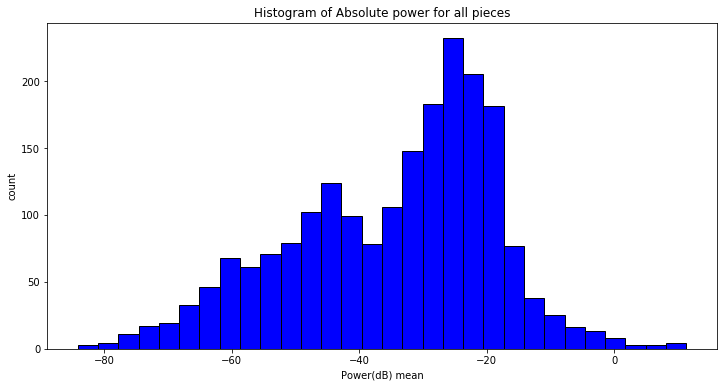

In [51]:
# histogram
plt.hist(df['Absolute power(dB)mean'], color = 'blue', edgecolor = 'black', bins=30)
plt.title('Histogram of Absolute power for all pieces')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

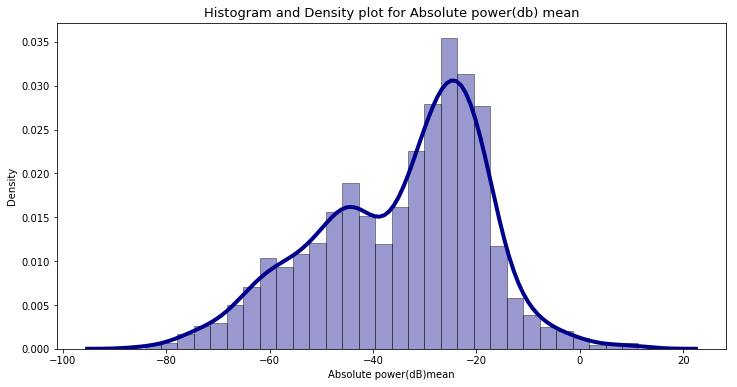

In [55]:
sns.distplot(df['Absolute power(dB)mean'], hist=True, kde=True, 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('Histogram and Density plot for Absolute power(db) mean', size = 13)
plt.ylabel('Density')

Text(0,0.5,'count')

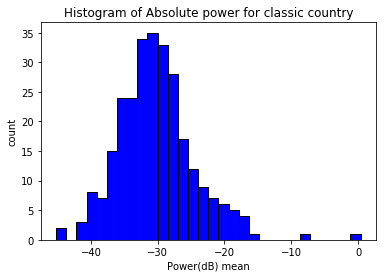

In [4]:
# matplotlib histogram
plt.hist(df_cc['Absolute power(dB)mean'], color = 'blue', edgecolor = 'black', bins=30)
# Add labels
plt.title('Histogram of Absolute power for classic country')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

Text(0,0.5,'count')

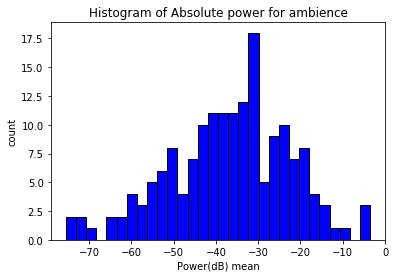

In [5]:
# matplotlib histogram
plt.hist(df_amb['Absolute power(dB)mean'], color = 'blue', edgecolor = 'black', bins=30)
# Add labels
plt.title('Histogram of Absolute power for ambience')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

Text(0.5,1,'Histogram of Absolute power')

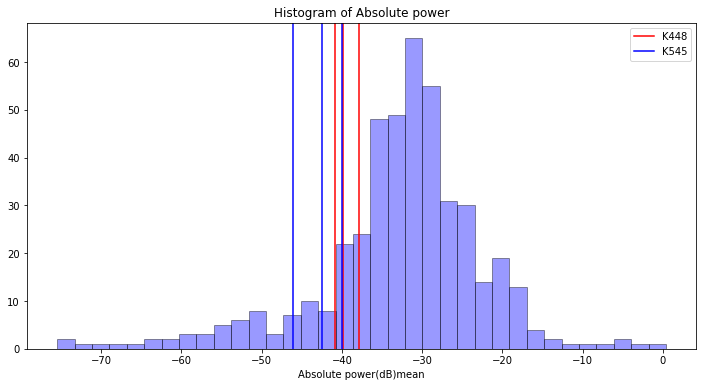

In [16]:
# seaborn histogram
sns.distplot(df['Absolute power(dB)mean'], hist=True, kde=False, bins=35, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.axvline(x=-40.87, color='red', label='K448')
plt.axvline(x=-39.85, color='red')
plt.axvline(x=-37.87, color='red')
plt.axvline(x=-46.14, color='blue', label='K545')
plt.axvline(x=-42.49, color='blue')
plt.axvline(x=-39.95, color='blue')
plt.legend()
plt.title('Histogram of Absolute power')

# Zooming in

(-50, -30)

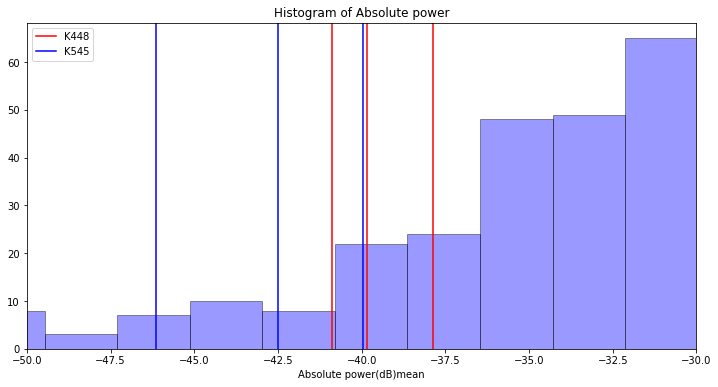

In [17]:
# seaborn histogram
sns.distplot(df['Absolute power(dB)mean'], hist=True, kde=False, bins=35, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.axvline(x=-40.87, color='red', label='K448')
plt.axvline(x=-39.85, color='red')
plt.axvline(x=-37.87, color='red')
plt.axvline(x=-46.14, color='blue', label='K545')
plt.axvline(x=-42.49, color='blue')
plt.axvline(x=-39.95, color='blue')
plt.legend()
plt.title('Histogram of Absolute power')
plt.xlim(-50, -30)

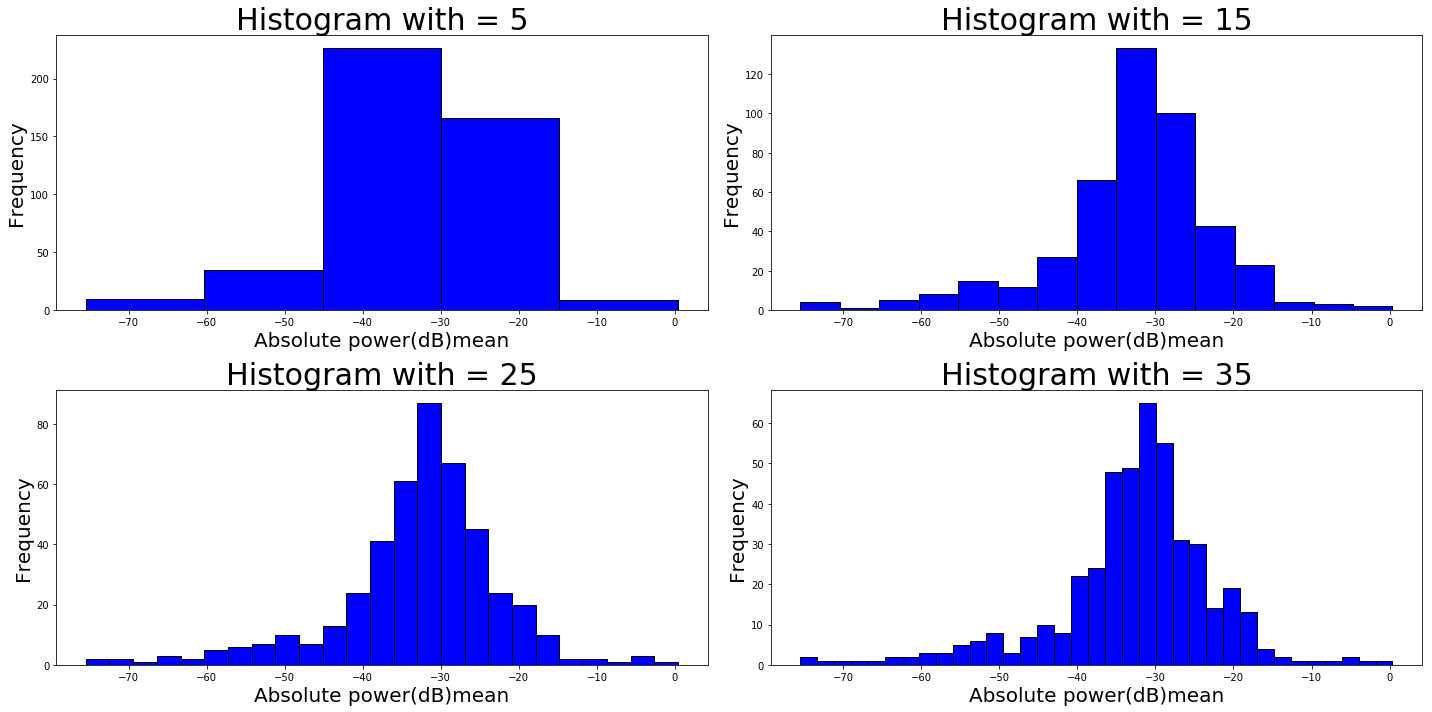

In [18]:
# Showing 4 different binwidths

plt.figure(figsize=(20,10))
for i, binwidth in enumerate([5, 15, 25, 35]):
    
    # Set up the plot
    #plt.figure(figsize=(5,10))
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(df['Absolute power(dB)mean'], bins = binwidth,
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with = %d' % binwidth, size = 30)
    ax.set_xlabel('Absolute power(dB)mean', size = 20)
    ax.set_ylabel('Frequency', size= 20)

plt.tight_layout()
plt.show()

## Mean Mod spec for different genres

In [ ]:
import seaborn as sns
sns.set_style("white")

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
#sns.distplot(x1, color="dodgerblue", label="Compact", **kwargs)
sns.distplot(sample_df_cc['Absolute power(dB)mean'].dropna(), color="orange", label="Classic Country", **kwargs)
sns.distplot(sample_df_amb['Absolute power(dB)mean'].dropna(), color="deeppink", label="Ambience", **kwargs)
#sns.distplot(sample_df_nw['Absolute power(dB)mean'].dropna(), color="b", label="Non Western", **kwargs)
sns.distplot(sample_df_class['Absolute power(dB)mean'].dropna(), color="red", label="Classical", **kwargs)
sns.distplot(sample_df_rnr['Absolute power(dB)mean'].dropna(), color="b", label="Rock n Roll", **kwargs)
sns.distplot(sample_df_hm['Absolute power(dB)mean'].dropna(), color="lime", label="Heavy Metal", **kwargs)


plt.legend();
plt.title('Density Plot for Different Genres', size = 18)
plt.xlabel('Power(dB) mean')
plt.ylabel('Density')
